In [3]:
from __future__ import print_function, division
from builtins import range

In [5]:
import gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler


In [6]:
def plot_running_avg(totalrewards):
  N = len(totalrewards)
  running_avg = np.empty(N)                  
  for t in range(N): 
    running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()                          
  plt.plot(running_avg)
  plt.title("Running Average")                                                                        
  plt.show()   

In [15]:
class SGDRegressor:
  def __init__(self, D):
    self.w = np.random.randn(D) / np.sqrt(D)
    self.lr = 0.1

  def partial_fit(self, X, Y):
    self.w += self.lr*(Y - X.dot(self.w)).dot(X)

  def predict(self, X):
    return X.dot(self.w)

In [16]:
class FeatureTransformer:                                      
  def __init__(self, env):                                     
    # observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
    # NOTE!! state samples are poor, b/c you get velocities --> infinity
    observation_examples = np.random.random((20000, 4))*2 - 1                          
    scaler = StandardScaler()      
    scaler.fit(observation_examples)           
    
    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=0.05, n_components=1000)),
            ("rbf2", RBFSampler(gamma=1.0, n_components=1000)),
            ("rbf3", RBFSampler(gamma=0.5, n_components=1000)),
            ("rbf4", RBFSampler(gamma=0.1, n_components=1000))
            ]) 
    feature_examples = featurizer.fit_transform(scaler.transform(observation_examples))
    
    self.dimensions = feature_examples.shape[1]
    self.scaler = scaler
    self.featurizer = featurizer
      
  def transform(self, observations):
    scaled = self.scaler.transform(observations)
    return self.featurizer.transform(scaled)


In [17]:
# Holds one SGDRegressor for each action
class Model:
  def __init__(self, env, feature_transformer):
    self.env = env
    self.models = []
    self.feature_transformer = feature_transformer
    for i in range(env.action_space.n):
      model = SGDRegressor(feature_transformer.dimensions)
      self.models.append(model)

  def predict(self, s):
    X = self.feature_transformer.transform(np.atleast_2d(s))
    result = np.stack([m.predict(X) for m in self.models]).T
    return result

  def update(self, s, a, G):
    X = self.feature_transformer.transform(np.atleast_2d(s))
    self.models[a].partial_fit(X, [G])

  def sample_action(self, s, eps):
    if np.random.random() < eps:
      return self.env.action_space.sample()
    else:
      return np.argmax(self.predict(s))


In [18]:
def play_one(env, model, eps, gamma):
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0
  while not done and iters < 2000:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    action = model.sample_action(observation, eps)
    prev_observation = observation
    observation, reward, done, info = env.step(action)

    if done:
      reward = -200

    # update the model
    next = model.predict(observation)
    # print(next.shape)
    assert(next.shape == (1, env.action_space.n))
    G = reward + gamma*np.max(next)
    model.update(prev_observation, action, G)

    if reward == 1: # if we changed the reward to -200
      totalreward += reward
    iters += 1

  return totalreward


In [19]:
def main():
  env = gym.make('CartPole-v0')
  ft = FeatureTransformer(env)
  model = Model(env, ft)
  gamma = 0.99

  if 'monitor' in sys.argv:
    filename = os.path.basename(__file__).split('.')[0]
    monitor_dir = './' + filename + '_' + str(datetime.now())
    env = wrappers.Monitor(env, monitor_dir)


  N = 500
  totalrewards = np.empty(N)
  costs = np.empty(N)
  for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(env, model, eps, gamma)
    totalrewards[n] = totalreward
    if n % 100 == 0:
      print("episode:", n, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())

  print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
  print("total steps:", totalrewards.sum())

  plt.plot(totalrewards)
  plt.title("Rewards")
  plt.show()

  plot_running_avg(totalrewards)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 0 total reward: 13.0 eps: 1.0 avg reward (last 100): 13.0
episode: 100 total reward: 199.0 eps: 0.09950371902099892 avg reward (last 100): 89.99009900990099
episode: 200 total reward: 199.0 eps: 0.07053456158585983 avg reward (last 100): 164.009900990099
episode: 300 total reward: 199.0 eps: 0.0576390417704235 avg reward (last 100): 163.54455445544554
episode: 400 total reward: 128.0 eps: 0.04993761694389223 avg reward (last 100): 179.98019801980197
avg reward for last 100 episodes: 175.57
total steps: 77182.0


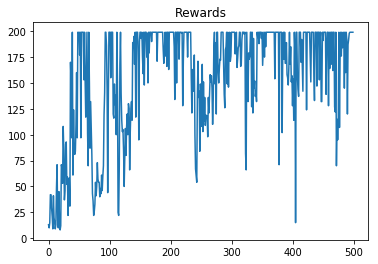

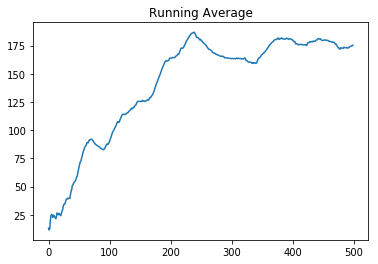

In [20]:
main()